# PROYECTO CIENCIA DE DATOS  -  Sistema de Asistencia para Limitados Visuales en la Unab

Integrantes:  Angiela Vargas Pérez
              Juan Pérez Bayona

Docente:      Alfredo Díaz Claro


**DESCRIPCIÓN:**

El objetivo es desarrollar una aplicación de ayuda para personas con discapacidad visual en la Universidad (Unab), que permita conocer de forma interactiva el Laboratorio Smart Region Lab. La aplicación capturará imágenes de diferentes áreas, identificará espacios y equipos, y generará información hablada acerca de cada uno. Además, contará con un sistema interactivo basado en una red generativa de voz y texto que responderá preguntas y ofrecerá más detalles a los usuarios.

**OBJETIVOS:**

***Accesibilidad y Orientación:***

Permitir que personas con limitaciones visuales puedan conocer los distintos espacios, áreas y equipos del Smart Region Lab mediante descripciones de audio.​

***Captura y Procesamiento de Imágenes:***

Utilizar técnicas de visión por computadora para reconocer y clasificar áreas y equipos a partir de fotografías.

***Generación de Información:***

Integrar un sistema de generación de voz y texto (mediante modelos generativos) que no solo describa los espacios, sino que también responda preguntas y amplíe la información según la interacción del usuario.

***Interactividad y Respuesta Dinámica:***

Ofrecer un sistema interactivo en el que el usuario pueda realizar consultas y recibir respuestas detalladas sobre los equipos, áreas y funciones de cada espacio.


### DESCRIPCIÓN DE LA DATASET

# EXPLORACIÓN Y PREPROCESAMIENTO DE LA DATASET

Se tomaron muestras de cada clase, son 20 clases, las cuales se van a aumentar para obtener un total de 50 datos por clase. Se debe asignar el tamaño de las imagenes y la cantidad de imagenes por lote o batch y asignarlo a la dt_aumentada.


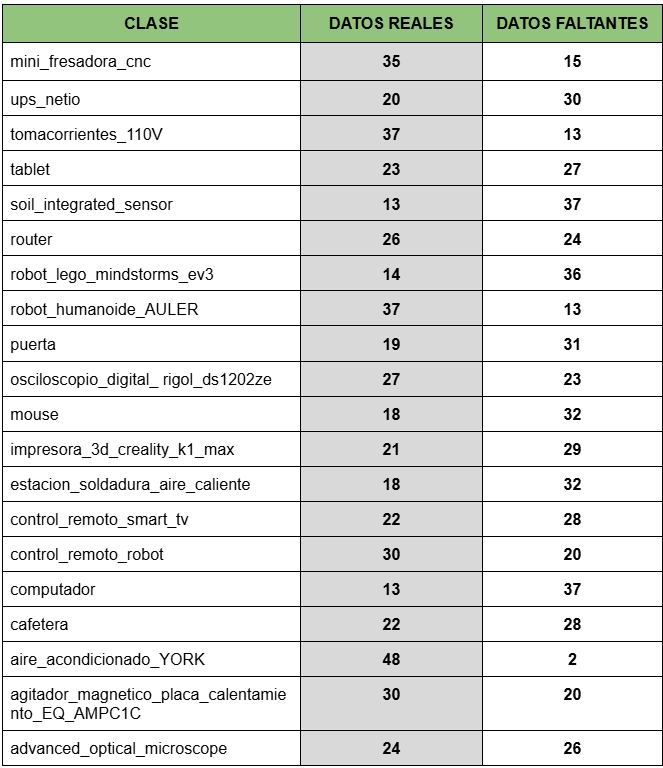


### Importar librerias

In [ ]:
# Necesarios para el entrenamiento del modelo - Se usa el modelo preentrenado VGG16
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions

# Necesarios para importar y aumentar la dataset
import zipfile
import os
import gdown
import requests
import urllib.request
from PIL import Image

# Tomar datos aleatorios
import random

# Necesarios para mostrar y visualizar mejor los datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Visualizamos la versión de tensor flow
tf.__version__

In [ ]:
# Visualizamos la versión de python
!python --version

### Importar la dataset

In [ ]:
# Se instala la librería gdown para descargar archivos desde Google Drive
!pip install gdown

In [ ]:
# Se guarda el id del documento y se crean los directorios donde se guardará
file_id = '1xj6-3_3vnvMy75W6L36Q4XXKvecJJAVS'
os.makedirs('/content/datasets', exist_ok=True)

# Se indica la ruta donde se guarda el archivo
path_to_zip = '/content/datasets/dataset_lab.zip'

# Se descarga el dataset_lab.zip desde google drive mediante el id del enlace al documento
gdown.download(f"https://drive.google.com/uc?id={file_id}", path_to_zip, quiet=False)

In [ ]:
# Se indica la ruta donde se guarda el archivo
extract_path = '/content/datasets/dataset_lab_extracted'

# Se descomprime el archivo
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Aumentar dataset

In [ ]:
# Se guarda la dataset descomprimida y se define donde se guardará la dataset aumentada
INPUT_DIR = '/content/datasets/dataset_lab_extracted/Dataset'
OUTPUT_DIR = '/content/datasets/dataset_aumentado'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Se parametrizan el tamaño de las imagenes y la cantidad de imagenes en total que se aumentarán
IMG_SIZE = (224, 224)
TARGET_IMAGES_PER_CLASS = 50

# Aumentación compatible con VGG16
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Función que permite cargar una imagen de la dataset y procesarla para el tamaño de imagen
def cargar_imagen(path):
    img = image.load_img(path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)
    return tf.convert_to_tensor(arr)

# Recorre las carpetas/clases de la dataset y las identifica
for clase in os.listdir(INPUT_DIR):
    ruta_clase = os.path.join(INPUT_DIR, clase)
    if not os.path.isdir(ruta_clase):
        continue

    # Va agregando los directorios de clases al directorio de salida
    destino_clase = os.path.join(OUTPUT_DIR, clase)
    os.makedirs(destino_clase, exist_ok=True)

    # Identifica las imagenes en la dataset
    imagenes = [f for f in os.listdir(ruta_clase) if f.lower().endswith(('.jpg', '.png'))]
    originales = [cargar_imagen(os.path.join(ruta_clase, f)) for f in imagenes]

    # Guarda las imagenes originales
    for idx, img_tensor in enumerate(originales):
        img_pil = Image.fromarray(np.uint8(img_tensor.numpy()))
        img_pil.save(os.path.join(destino_clase, f"original_{idx}.jpg"))

    # Se calcula por clases cuántas imagenes faltan (50 por clase)
    faltantes = TARGET_IMAGES_PER_CLASS - len(originales)

    # Se escogen imagenes aleatorias para aumentar por clase hasta alcanzar 50 imagenes
    for i in range(faltantes):
        base_img = random.choice(originales)
        img_aug = data_augmentation(tf.expand_dims(base_img, 0))[0] # Se transforma la imagen con flip, rotación, zoom y ajuste de contraste
        img_aug = tf.clip_by_value(img_aug, 0, 255) # Se normalizan los pixeles de 0 a 255
        img_pil = Image.fromarray(np.uint8(img_aug.numpy())) # Se convierte en formato PIL (imagenes)
        img_pil.save(os.path.join(destino_clase, f"augmented_{i}.jpg")) # Se guardan las imagenes aumentadas

    print(f"[✔] Clase '{clase}' lista con 50 imágenes.")


### Descargar la dataset aumentada

In [ ]:
import shutil

# Comprime la carpeta con el dataset aumentado
shutil.make_archive('/content/datasets/dataset_aumentado', 'zip', '/content/datasets/dataset_aumentado')


In [ ]:
from google.colab import files

# Descargar el archivo comprimido
files.download('/content/datasets/dataset_aumentado.zip')


# PREPROCESAMIENTO DE LA DATASET

Aumentar los datos para que la dataset esté normalizada con una cantidad de 50 datos por clase. Se debe asignar el tamaño de las imagenes y la cantidad de imagenes por lote o batch y asignarlo a la dt_aumentada.

## Importar la dataset aumentada y la filtrada

In [ ]:
# Descarga el archivo dataset_lab_filtered.zip ubicado en GitHub
os.makedirs('/content/datasets', exist_ok=True)
!wget https://github.com/Angiela-Vargas/Data-Science-Gallery/raw/172fa4711bb74a232a0f29fb0da2e43c30b7b187/dataset_lab_filtered.zip -O /content/datasets/dataset_lab_filtered.zip


# Extraer el archivo filtrado
with zipfile.ZipFile('/content/datasets/dataset_lab_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

In [ ]:
# Se asignan los datos de entrenamiento y de validacion del dataset_lab_filtered
PATH = '/content/datasets/dataset_lab_filtered'

train_dir = os.path.join(PATH, '/content/datasets/dataset_lab_filtered/entrenamiento')
validation_dir = os.path.join(PATH, '/content/datasets/dataset_lab_filtered/validacion')

BATCH_SIZE = 20
IMG_SIZE = (224, 224)

# Crear los datasets de entrenamiento y validación
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='int')

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='int')

In [ ]:
# Obtener las clases
class_names = train_dataset.class_names

# Mostrar algunas imágenes del conjunto de entrenamiento
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Dividir el conjunto de validación y prueba

In [ ]:
# Dividir el conjunto de validación para prueba y validación
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# Se muestran los lotes para validación y prueba
print('Número de lotes de validación: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de lotes de prueba: %d' % tf.data.experimental.cardinality(test_dataset))

## VGG16

In [ ]:
# Preprocesamiento de la imagen para VGG16
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Preprocesamiento para normalizar imagenes a VGG16
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
# Crear el modelo base VGG16 preentrenado
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Usando pesos preentrenados de ImageNet
    input_shape=(224, 224, 3),  # Tamaño de la imagen de entrada (224x224 píxeles, 3 canales para RGB)
    include_top=False  # No incluir la capa superior (capa de clasificación final)
)

In [ ]:
# Congelar las capas del modelo base
base_model.trainable = False

In [ ]:
# Visualizar la arquitectura del modelo base que se usará
base_model.summary()

## Diseñar el modelo

In [ ]:
# Añadir capas adicionales para nuestra tarea específica (dispositivos del laboratorio)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')

In [ ]:
capa1= tf.keras.layers.Dense(128, activation='relu')

In [ ]:
from tensorflow.keras import layers, models, Input

# Construir el modelo completo
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)  # Usar el modelo base VGG16 sin entrenar
x = global_average_layer(x)  # Promediar las características extraídas
x = tf.keras.layers.Dropout(0.2)(x)  # Regularización mediante Dropout
x = layers.Dense(256, activation='relu')(x) # Capa densa adicional
x = capa1(x)  # Capa intermedia
outputs = prediction_layer(x)  # Capa de salida

model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compilar el modelo
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Visualizar la arquitectura del modelo construido
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
for images, labels in train_dataset.take(1):  # Toma un solo lote
    print("Shape de imágenes:", images.shape)
    print("Shape de etiquetas:", labels.shape)
    print("Ejemplo de etiqueta:", labels[0].numpy())
    break


# Entrenamiento

Se usará el modelo pre entrenado VGG16 el cual tiene los siguientes parámetros:

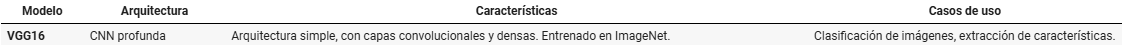


1. **Tamaño de entrada:**
   - Usa un tamaño de entrada adecuado para el modelo 224x224.
2. **Número de capas:**
   - Congela las capas iniciales y ajusta finamente solo las capas finales si los datos de destino son similares al conjunto de datos original.
3. **Regularización:**
   - Usa técnicas como dropout y regularización L2 para prevenir sobreajuste.
4. **Optimización del entrenamiento:**
   - Ajusta el learning rate con un optimizador como Adam o SGD con programación de aprendizaje.

In [ ]:
# Entrenamiento del modelo
initial_epochs = 25
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Análisis y evaluación del modelo

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"🔎 Accuracy en test: {test_acc:.4f} - Loss: {test_loss:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tomar un lote del test_dataset
for images, labels in test_dataset.take(1):
    # Realizar predicciones
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Mostrar las imágenes con sus etiquetas
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        real = class_names[labels[i]]
        pred = class_names[predicted_labels[i]]
        color = "green" if real == pred else "red"
        plt.title(f"Real: {real}\nPred: {pred}", color=color)
        plt.axis("off")
    break


In [ ]:
# Mostrar las gráficas de precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Guardar el modelo

In [ ]:
import h5py

# Guardar history en un archivo .h5
with h5py.File('historial_entrenamiento.h5', 'w') as f:
    for key, values in history.history.items():
        f.create_dataset(key, data=values)


In [ ]:
model.save('modelo_entrenado.h5')
